# Exploring the chemical properties between medicinal and non medicinal plants

### Import modules

In [1]:
from collections import defaultdict
import random
import string

import pandas as pd
from tqdm import tqdm

# Cheminformatics
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit import RDLogger  

from rdkit import Chem
from rdkit.Chem import MolFromSmiles, Descriptors

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
RDLogger.DisableLog('rdApp.*')

In [3]:
%matplotlib inline

In [4]:
random.seed(123)

In [5]:
mpl.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")

Load plant-disease evidences

In [6]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

In [7]:
plant_disease_df.head(1)

,plant_curie,disease_curie
0,ncbitaxon:3369,mondo:0005324


In [8]:
plant_disease_dict = defaultdict(set)

for plant_curie, disease_curie in tqdm(plant_disease_df.values):
    plant_disease_dict[plant_curie].add(disease_curie)

100%|██████████| 97066/97066 [00:00<00:00, 698250.98it/s]


In [9]:
medicinal_plants = set(plant_disease_df.plant_curie.unique())

Load plant-chemical evidences

In [10]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ],
)

In [11]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [12]:
len(plant_chemical_df.chemical_curie.unique())

71179

In [13]:
plant_ids = set(plant_chemical_df.plant_curie.unique())

Number of medicinal and non-medicinal plants

In [14]:
len(plant_ids), len(set(plant_chemical_df.plant_curie.unique()) - medicinal_plants)

(18094, 14066)

Get SMILES

In [15]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [16]:
smiles_df.head(1)

,pubchem_id,smiles
0,pubchem:3527,CC(=CCCC1(C(CC2(C(=O)C(=C(C3=CC(=C(C=C3)O)O)O)...


In [17]:
smiles_df.shape

(71179, 2)

In [18]:
murcko_from_pubchem_id = {}
skipped_murcko = 0
skipped_smiles = 0
skipped_wt = 0

smiles_to_property_dict = {}

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    """Calculate some properties"""
    try:
        molecule = MolFromSmiles(smiles)
    except:
        skipped_smiles += 1
        continue
    try:
        molecular_weight = Descriptors.ExactMolWt(molecule)
    except:
        skipped_wt += 1
        continue  

    logp = Descriptors.MolLogP(molecule)
    topological_surface_area_mapping = Chem.QED.properties(molecule).PSA
    fsp3 = Chem.Lipinski.FractionCSP3(molecule)
    
    smiles_to_property_dict[pubchem_id] = {
        'molecular_weight': molecular_weight,
        'logp': logp,
        'topological_surface_area_mapping': topological_surface_area_mapping,
        'fsp3': fsp3,
    }
    
    """Murcko scaffold"""
    try:
        murcko_smiles = Chem.MolToSmiles(GetScaffoldForMol(molecule))
    except:
        skipped_murcko += 1
        continue
        
    if not murcko_smiles:
        skipped_murcko += 1
        continue
        
    murcko_from_pubchem_id[pubchem_id] = murcko_smiles

100%|██████████| 71179/71179 [04:34<00:00, 258.88it/s]


In [19]:
len(murcko_from_pubchem_id), skipped_murcko, skipped_smiles, skipped_wt

(67546, 3633, 0, 0)

Prepare plant-chemicals dicts

In [20]:
plant_chem_dict = defaultdict(set)
plant_scaffolds_dict = defaultdict(set)

chemicals_to_plant_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    
    plant_chem_dict[plant_curie].add(chemical_curie)
    chemicals_to_plant_dict[chemical_curie].add(plant_curie)
    
    if chemical_curie in murcko_from_pubchem_id:
        plant_scaffolds_dict[plant_curie].add(murcko_from_pubchem_id[chemical_curie])

100%|██████████| 330655/330655 [00:01<00:00, 226460.34it/s]


### Explore distributions

We will apply a filter to avoid artifacts caused by these chemical outliers (chemicals present in a lot of plants)

In [21]:
# Remove chemicals that are prenent in more than 100 plants

promiscuous_chemicals = [
    chemical
    for chemical, plants in chemicals_to_plant_dict.items()
    if len(plants) > 100
]

plant_chem_dict = {
    plant: {
        chemical
        for chemical in chemicals
        if chemical not in promiscuous_chemicals
    }
    for plant, chemicals in plant_chem_dict.items()
}

In [22]:
len(promiscuous_chemicals)

262

In [23]:
len(chemicals_to_plant_dict) - len(promiscuous_chemicals)

70917

### Ensuring the properties of the chemicals are maintained

In [24]:
df1 = pd.DataFrame([
    {
        "Plants": "Non medicinal plants",
        "molecular_weight": smiles_to_property_dict[chemical]['molecular_weight'],
        "logp": smiles_to_property_dict[chemical]['logp'],
        "fsp3": smiles_to_property_dict[chemical]['fsp3'],
        "topological_surface_area_mapping": smiles_to_property_dict[chemical]['topological_surface_area_mapping'],
    }
    for chemical in {
        chemical
        for plant, chemicals in plant_chem_dict.items()
        if plant not in medicinal_plants
        for chemical in chemicals
    }
    if chemical in smiles_to_property_dict
])

df2 = pd.DataFrame([
    {
        "Plants": "Medicinal plants",
        "molecular_weight": smiles_to_property_dict[chemical]['molecular_weight'],
        "logp": smiles_to_property_dict[chemical]['logp'],
        "fsp3": smiles_to_property_dict[chemical]['fsp3'],
        "topological_surface_area_mapping": smiles_to_property_dict[chemical]['topological_surface_area_mapping'],
    }
    for chemical in {
        chemical
        for plant, chemicals in plant_chem_dict.items()
        if plant in medicinal_plants
        for chemical in chemicals
    }
    if chemical in smiles_to_property_dict
])

chemical_properties_df = pd.concat([df1, df2])

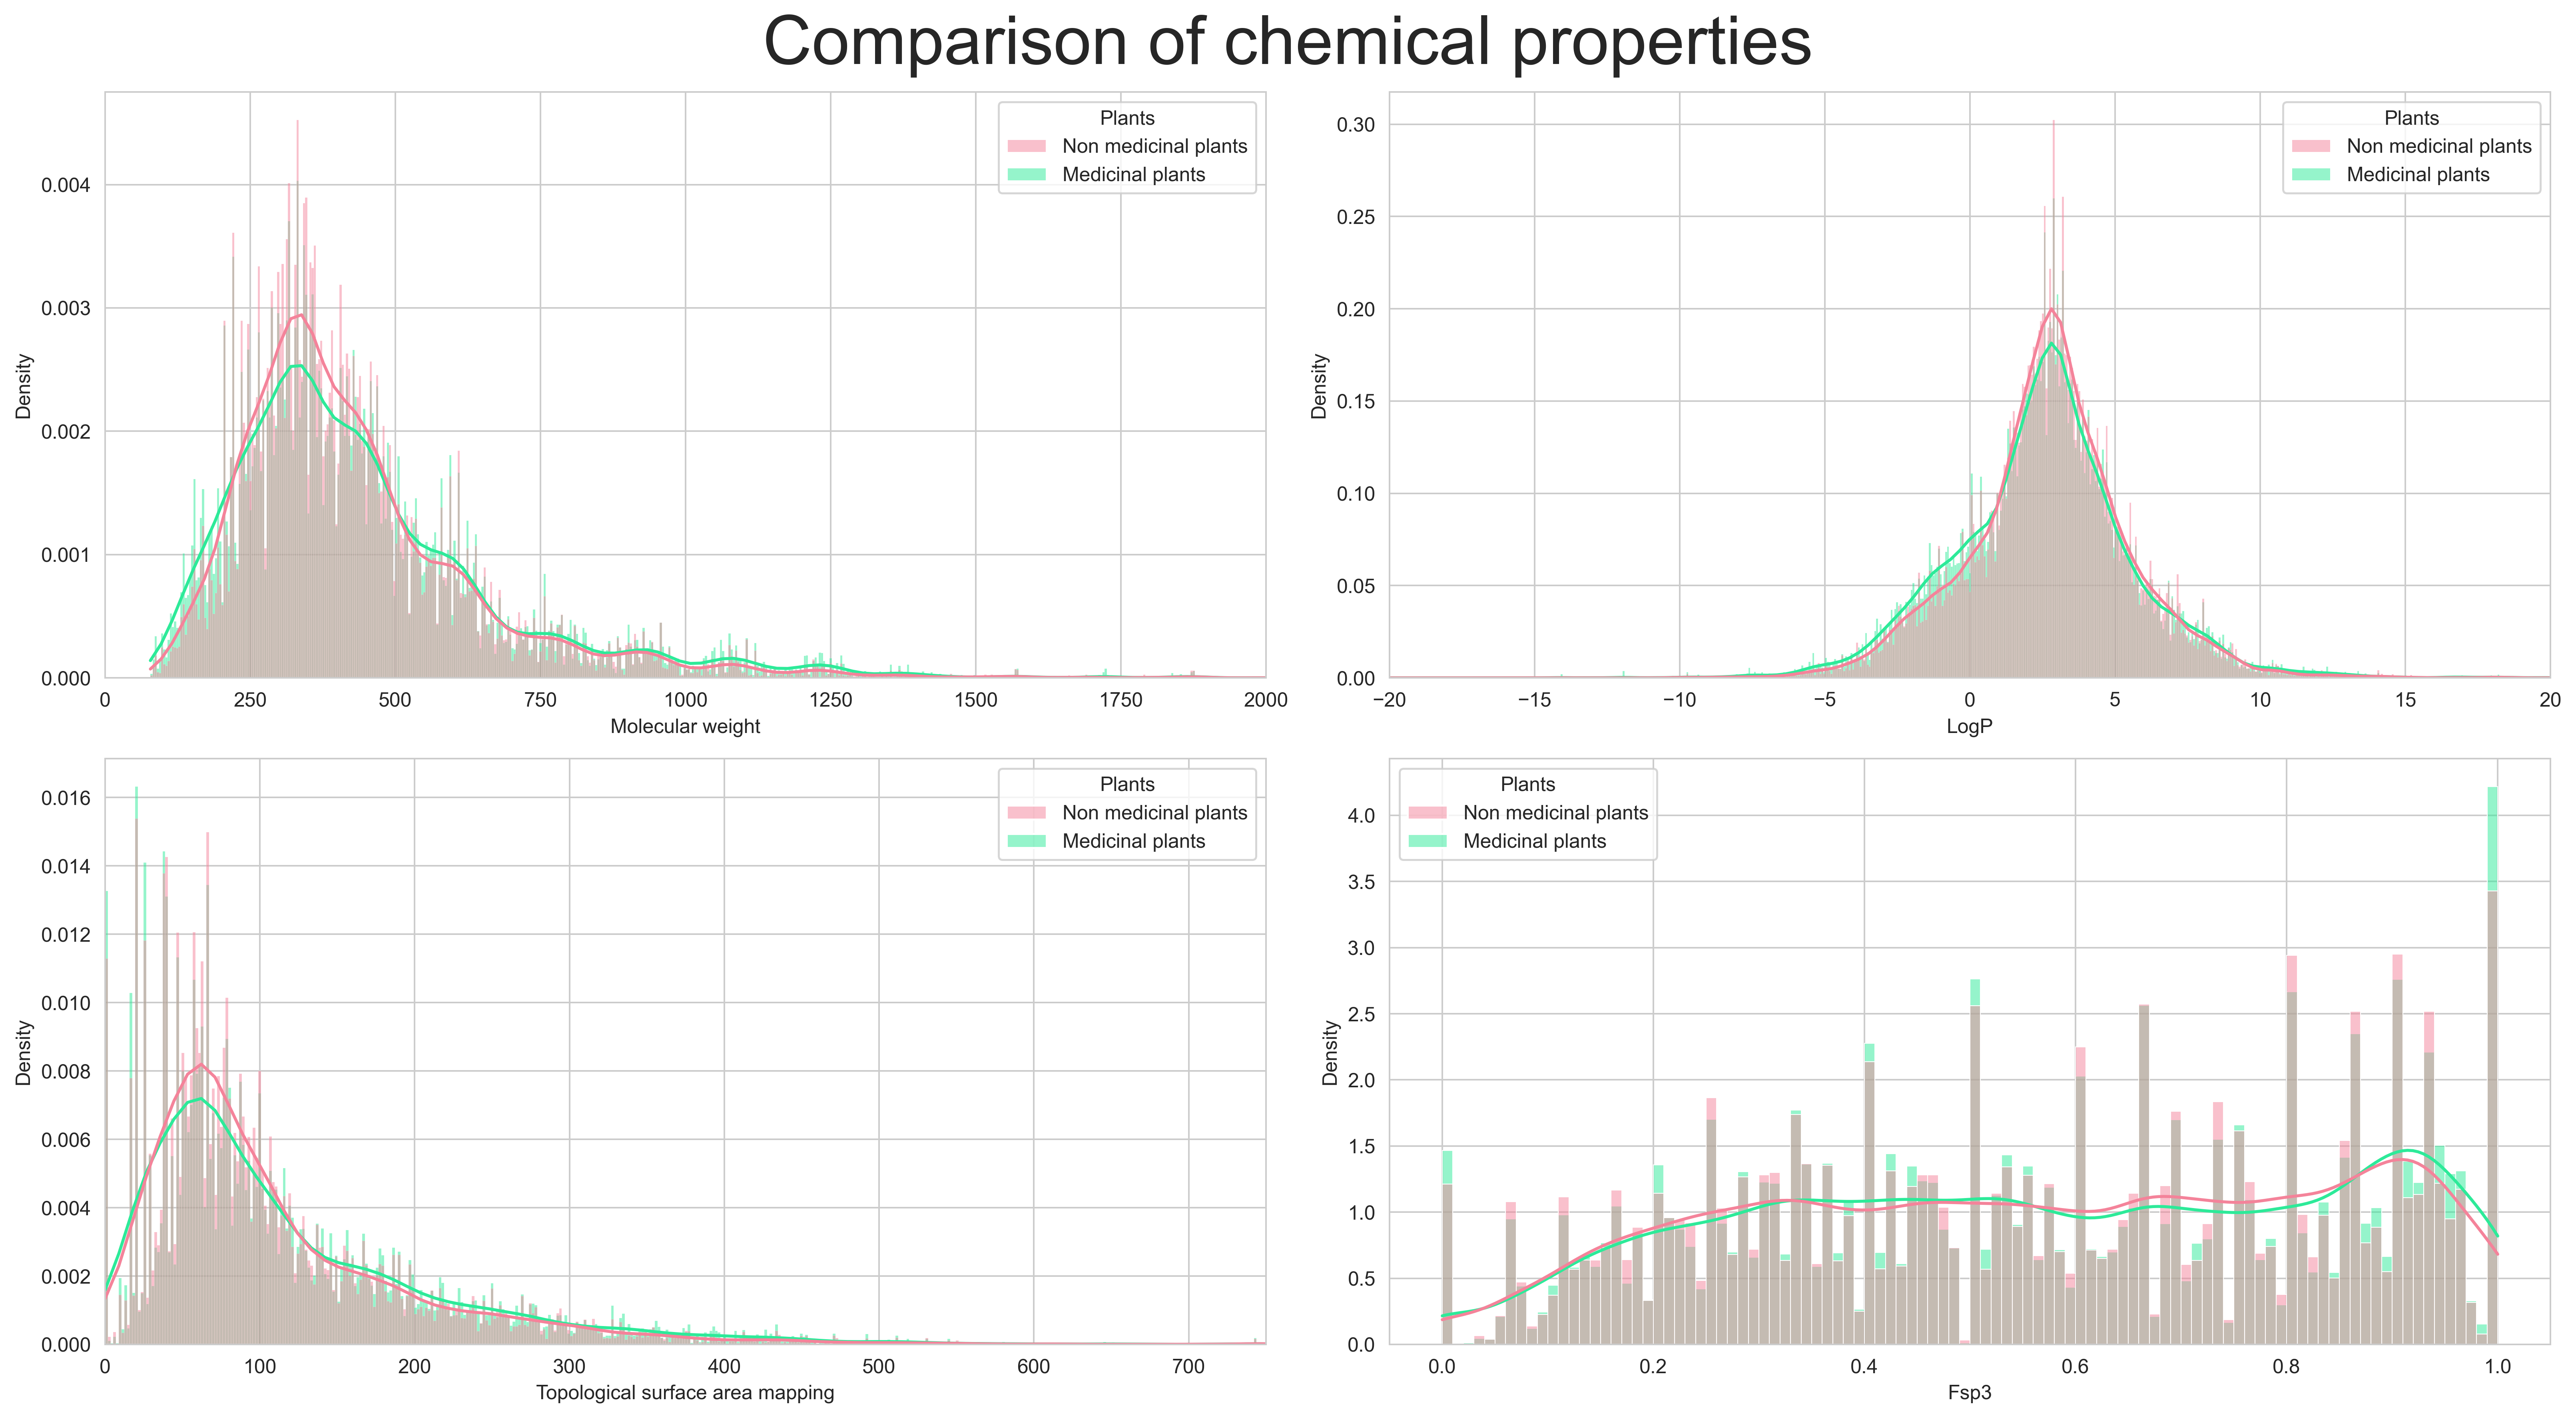

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Comparison of chemical properties', fontsize=34)

sns.histplot(
    ax=axes[0, 0],
    data=chemical_properties_df,
    x='molecular_weight',
    hue='Plants',
    kde=True,
    common_norm=False,
    stat="density",
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[0, 0].set(xlabel='Molecular weight')
axes[0, 0].set_xlim(0, 2000)

sns.histplot(
    ax=axes[0, 1],
    data=chemical_properties_df,
    x='logp',
    hue='Plants',
    kde=True,
    stat="density",
    common_norm=False,
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[0, 1].set(xlabel='LogP')
axes[0, 1].set_xlim(-20, 20)

sns.histplot(
    ax=axes[1, 0],
    data=chemical_properties_df,
    x='topological_surface_area_mapping',
    hue='Plants',
    stat="density",
    kde=True,
    common_norm=False,
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[1, 0].set(xlabel='Topological surface area mapping')
axes[1, 0].set_xlim(0, 750)

sns.histplot(
    ax=axes[1, 1],
    data=chemical_properties_df,
    x='fsp3',
    hue='Plants',
    kde=True,
    stat="density",
    common_norm=False,
    alpha=0.5,
    bins=100,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[1, 1].set(xlabel='Fsp3')

plt.tight_layout()

plt.savefig(
    f'figure_4a.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()

### Exploring scaffold diversity

In [26]:
medicinal_plants_scaffolds = set()
non_medicinal_plants_scaffolds = set()

skipped = set()
valid_scaffolds = set()

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    
    if chemical_curie not in murcko_from_pubchem_id:
        skipped.add(chemical_curie)
        continue

    valid_scaffolds.add(chemical_curie)

    if plant_curie in medicinal_plants:
        medicinal_plants_scaffolds.add(murcko_from_pubchem_id[chemical_curie])
    else:
        non_medicinal_plants_scaffolds.add(murcko_from_pubchem_id[chemical_curie])

100%|██████████| 330655/330655 [00:00<00:00, 393557.75it/s]


In [27]:
len(skipped), len(valid_scaffolds)

(3633, 67546)

In [28]:
medicinal_plants_scaffolds = set()
non_medicinal_plants_scaffolds = set()

medicinal_plants_structures = set()
non_medicinal_plants_structures = set()

skipped = set()
valid_scaffolds = set()

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    
    if chemical_curie in promiscuous_chemicals:
        continue
    
    if chemical_curie not in murcko_from_pubchem_id or not murcko_from_pubchem_id[chemical_curie]:
        skipped.add(chemical_curie)
        continue

    valid_scaffolds.add(chemical_curie)

    if plant_curie in medicinal_plants:
        medicinal_plants_scaffolds.add(murcko_from_pubchem_id[chemical_curie])
        medicinal_plants_structures.add(chemical_curie)
    else:
        non_medicinal_plants_scaffolds.add(murcko_from_pubchem_id[chemical_curie])
        non_medicinal_plants_structures.add(chemical_curie)

100%|██████████| 330655/330655 [00:02<00:00, 131357.52it/s]


In [29]:
len(skipped), len(valid_scaffolds)

(3592, 67325)

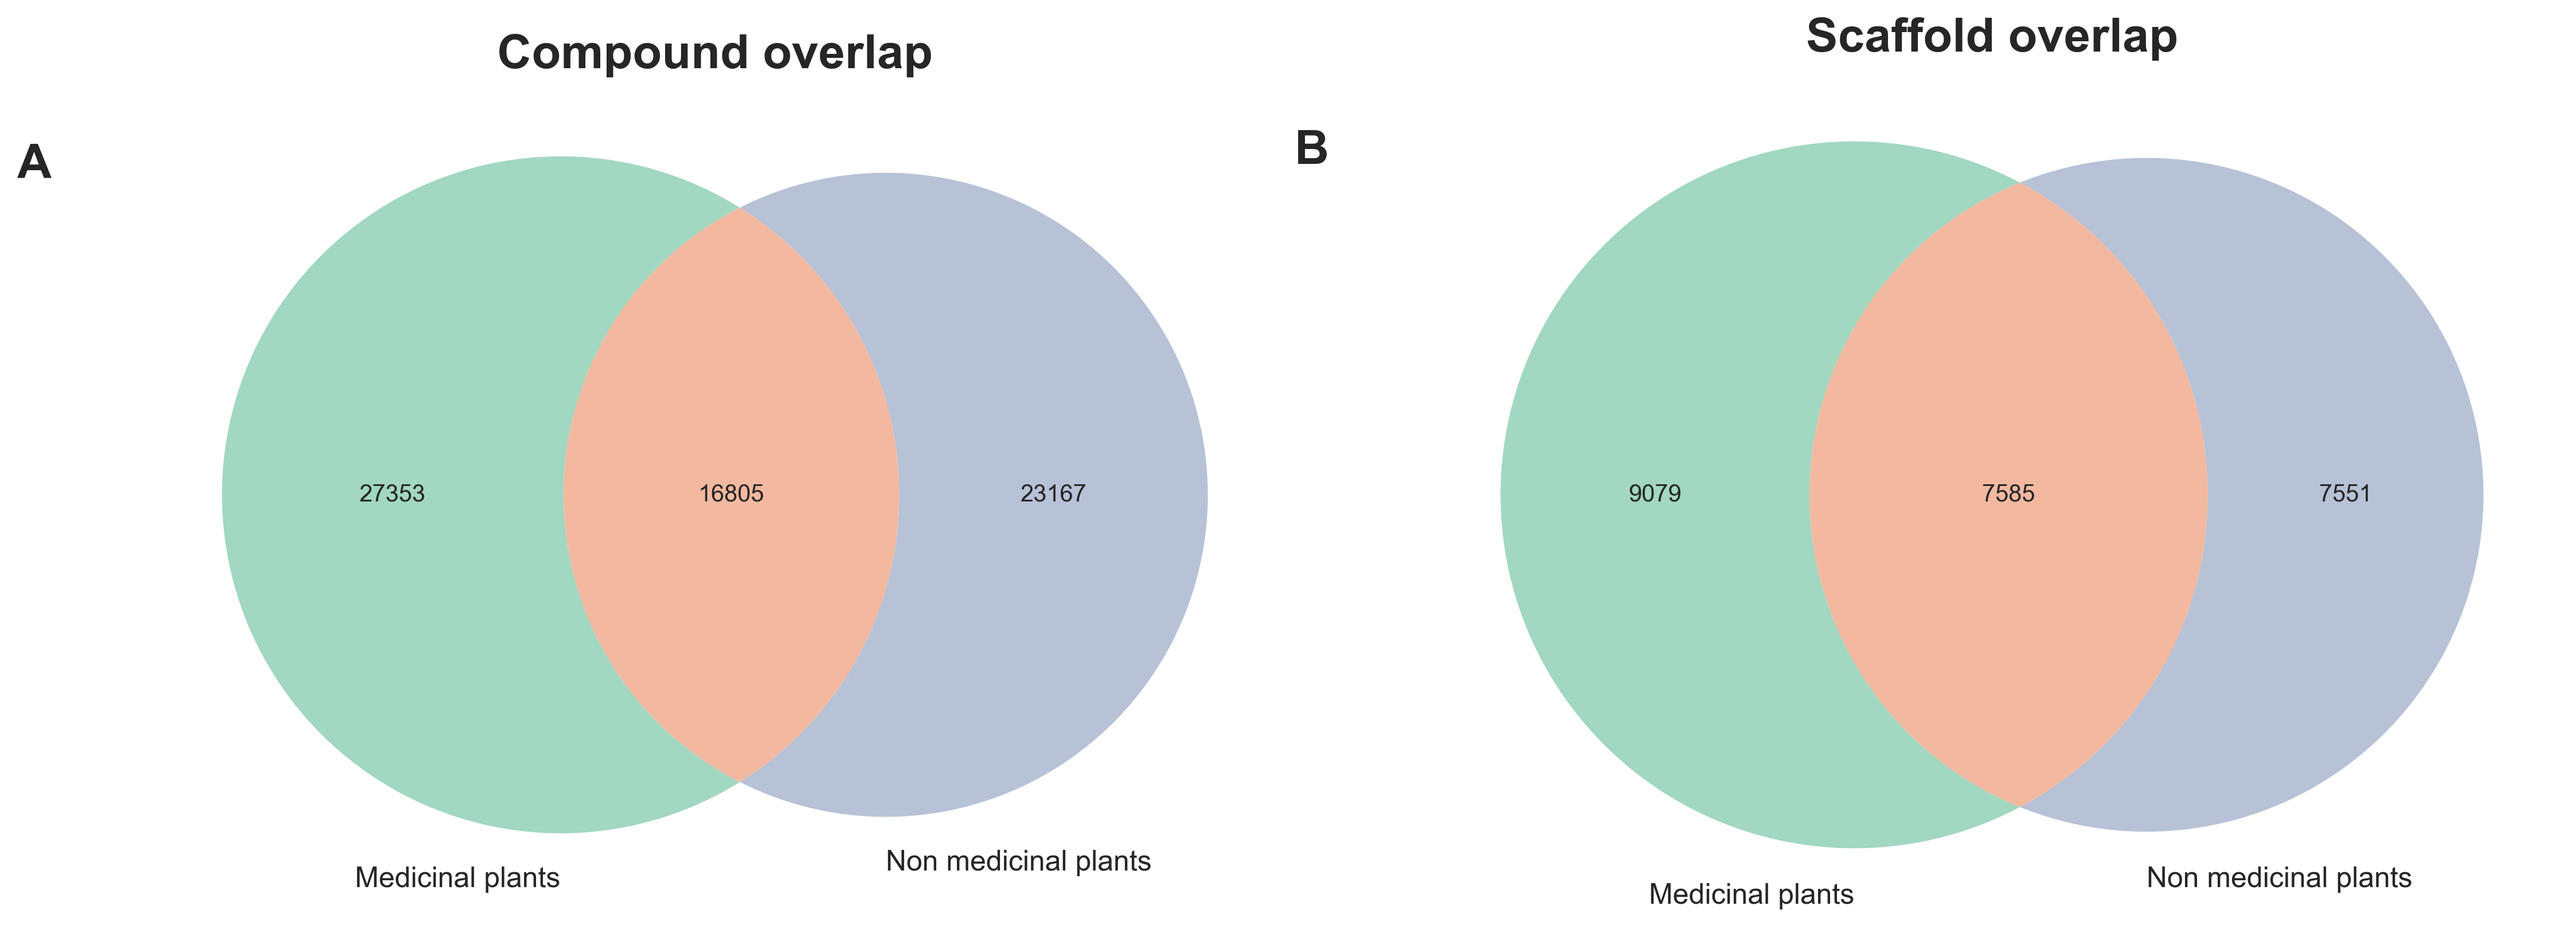

In [30]:
plt.figure(dpi=300, figsize=([15,15]))

plt.subplots_adjust(wspace=0)

plt.subplot(1,2,1)

plt.title('Compound overlap', fontsize=20, fontweight='bold')

c3 = venn2(
    [medicinal_plants_structures, non_medicinal_plants_structures],
    ('Medicinal plants', 'Non medicinal plants'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8,
)
c3.get_patch_by_id('11').set_color('#efa888')
c3.get_patch_by_id('11').set_edgecolor('none')

plt.text(-0.1, 0.9, string.ascii_uppercase[0],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(1,2,2)

plt.title('Scaffold overlap', fontsize=20, fontweight='bold')

c3 = venn2(
    [medicinal_plants_scaffolds, non_medicinal_plants_scaffolds],
    ('Medicinal plants', 'Non medicinal plants'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8,
)
c3.get_patch_by_id('11').set_color('#efa888')
c3.get_patch_by_id('11').set_edgecolor('none')

plt.text(
    -0.1, 0.9,
    string.ascii_uppercase[1],  
    size=20,
    weight='bold',
    horizontalalignment='center',
    verticalalignment='center',
    transform = plt.gca().transAxes,


plt.tight_layout()
plt.savefig(f'figure_4b.png', bbox_inches='tight')
plt.show()